* Customer Complaint Notebook

In [1]:
# import libraries
import logging
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("customer_complaint_bot")

# Load environment variables (for Groq API key)
load_dotenv()

# Initialize LLM (using Groq’s Llama 3.1)
# llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)openai/gpt-oss-20b
llm = ChatGroq(model="openai/gpt-oss-20b", temperature=0)


In [2]:
class AgentState(TypedDict):
    """
    The state of our customer complaint agent.
    """
    # 'add_messages' is a special modifier that appends
    # new messages to the list, rather than overwriting it.
    messages: Annotated[list, add_messages]
    
    # The original customer email
    original_email: str
    
    # The final summary
    summary: str

In [3]:
def summarise_complaint(state: AgentState):
    """
    A node that takes the customer input from the state
    and generates a summary.
    """

    email = state["messages"][-1].content
    logger.info(f"Summarising customer email: {email}")

    prompt = f"""
    You are an expert customer service agent. Please summarise the following
    customer complaint email concisely. Extract the core issue. 
    If the customer asks questions, use the tools at your disposal when needed
    to provide suggested response. DO NOT answer the questions yourself.
    Do not add any formatting.
    
    Email:
    {email}
    
    Summary:

    Response:
    """
    
    response = llm.invoke(prompt)
    summary = response.content
    logger.info("Summary generated successfully.")
    
    # Return a dictionary to update the state
    return {"original_email": email, "summary": summary}

In [4]:
# 1. Initialize the graph
customer_complaint_bot = StateGraph(AgentState)

# 2. Add the nodes
customer_complaint_bot.add_node("summarise", summarise_complaint)

# 3. Define the edges
customer_complaint_bot.add_edge(START, "summarise")
customer_complaint_bot.add_edge("summarise", END)

# 4. Compile the graph
app_stage1 = customer_complaint_bot.compile()

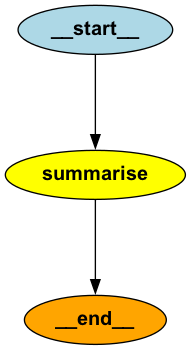

In [5]:
from IPython.display import Image, display

# Get the graph object
graph = app_stage1.get_graph()

# Draw it as a PNG (returns raw bytes)
png_bytes = graph.draw_png()

# Display the PNG in the notebook
display(Image(png_bytes))

In [6]:
# Define a sample complaint
complaint_email = (
    "Hi, I bought the 'SuperWidget 5000' (Order #A-12345) last week and "
    "it arrived broken. The screen is cracked. I tried calling support "
    "but was on hold for 45 minutes. This is unacceptable. I want a "
    "full refund and a return label."
)

# Invoke the graph
# We pass the input as the 'messages' list
inputs = {"messages": [HumanMessage(content=complaint_email)]}
result = app_stage1.invoke(inputs)

print(f"Summary: {result['summary']}")

INFO:customer_complaint_bot:Summarising customer email: Hi, I bought the 'SuperWidget 5000' (Order #A-12345) last week and it arrived broken. The screen is cracked. I tried calling support but was on hold for 45 minutes. This is unacceptable. I want a full refund and a return label.
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.


Summary: Summary: Customer received a broken SuperWidget 5000 with a cracked screen, had a long hold on support, and requests a full refund and a return label.  

Response: Apologize for the inconvenience, confirm receipt of the order, assure a full refund will be processed, and provide a prepaid return shipping label. Offer a quick resolution timeline and thank the customer for bringing the issue to your attention.


# Tool Calling

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import tool
from langchain_core.messages import SystemMessage, ToolMessage

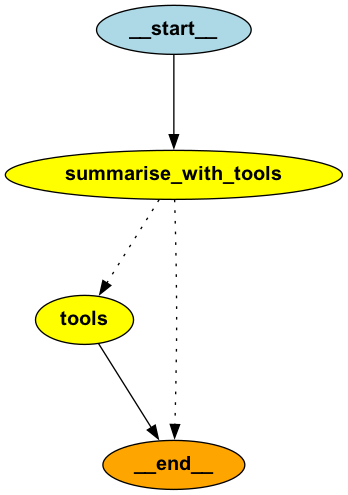

In [8]:
# Define a tool to get order details
def get_order_details(order_id: str) -> dict:
    """Retrieve order details by order ID from mock database.
     ️Args:
        order_id (str): The order ID to look up.
    Returns:
        dict: A dictionary with order details.
    """
    logger.info(f"Retrieving details for order ID: {order_id}")

    # Mock database
    mock_db = {
        "A-12345": {"product": "SuperWidget 5000", "status": "Delivered", "price": "£299"},
        "B-54321": {"product": "MegaWidget 2000", "status": "Shipped", "price": "£149"},
    }

    order = mock_db.get(order_id, {"error": "Order not found"})
    return order

# Define the tool node
tools = [get_order_details] # More tools can be added as required
tool_node = ToolNode(tools=tools)

# Bind the tools to the LLM - ensuring LLM can call them
llm_with_tools = llm.bind_tools(tools)

# Redefine the summarise_complaint function to include tool usage
def tooled_summarise_complaint(state: AgentState):
    original_email = state.get("original_email") or state["messages"][-1].content
    messages = state.get("messages", [])

    # Extract any tool responses so far
    tool_messages = [m.content for m in messages if isinstance(m, ToolMessage)]

    # Build the new LLM input
    llm_input = [
        SystemMessage(content=(
            "You are an expert customer service agent. "
            "Summarise the customer's complaint and interpret any tool results below. "
            "Use the tool outputs to answer questions accurately. "
            "Always keep the original email context."
        )),
        HumanMessage(content=original_email),
    ] + tool_messages  # <-- add all tool results here
    
    response = llm_with_tools.invoke(llm_input)
    print(f"LLM Response: {response}")
    summary = response.content
    logger.info("Summary generated successfully.")

    # Return a dictionary to update the state
    return {"messages": response, "original_email": original_email, "summary": summary}

# build a new graph incorporating the tool node
customer_complaint_bot_with_tools = StateGraph(AgentState)
customer_complaint_bot_with_tools.add_node("summarise_with_tools", tooled_summarise_complaint)
customer_complaint_bot_with_tools.add_node("tools", tool_node)

# Define the edges with tool condition
customer_complaint_bot_with_tools.add_edge(START, "summarise_with_tools")
customer_complaint_bot_with_tools.add_conditional_edges(
    "summarise_with_tools",
    tools_condition,   # built-in condition to check for tool calls
)
customer_complaint_bot_with_tools.add_edge("tools", END)

#  Compile the new graph
app_stage2 = customer_complaint_bot_with_tools.compile()

# display the new graph
graph = app_stage2.get_graph()
png_bytes = graph.draw_png()
display(Image(png_bytes))

In [9]:
# # call the new graph with the same input
# result_with_tools = app_stage2.invoke(inputs)
# print(f"Summary with tools: {result_with_tools['summary']}")

# call the new graph with a new input that requires tool use
new_complaint_email = (
    "Hello, I ordered the 'MegaWidget 2000' with order ID B-54321 two days ago, "
    "but I haven't received any shipping updates. Can you check the status of my order? "
    "Also, I want to confirm the price I was charged."
)
new_inputs = {"messages": [HumanMessage(content=new_complaint_email)]}
new_result = app_stage2.invoke(new_inputs)
print(f"New Summary with tools: {new_result['summary']}")   


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.
INFO:customer_complaint_bot:Retrieving details for order ID: B-54321


LLM Response: content='' additional_kwargs={'reasoning_content': 'We need to retrieve order details via function get_order_details with order_id "B-54321". Then summarize complaint and interpret tool results.', 'tool_calls': [{'id': 'fc_a79f560c-b54d-4e5b-9e65-b0468d6cf9a1', 'function': {'arguments': '{"order_id":"B-54321"}', 'name': 'get_order_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 246, 'total_tokens': 303, 'completion_time': 0.057276418, 'prompt_time': 0.013776259, 'queue_time': 0.0364378, 'total_time': 0.071052677, 'completion_tokens_details': {'reasoning_tokens': 29}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_a4315eb300', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--c03401b8-72c8-479a-b066-b5dc669b0a5f-0' tool_calls=[{'name': 'get_order_details', 'args': {'order_id': 'B-54321'}, 'id': 'fc_a79f560c-b54d-4e5b-9e65-b0468d6cf

# ReAct Architecture

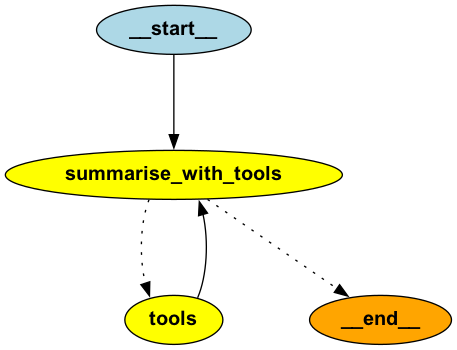

In [10]:
#    ReAct Architecture
# # Define the edges with tool condition
# customer_complaint_bot_with_tools.add_edge(START, "summarise_with_tools")
# customer_complaint_bot_with_tools.add_conditional_edges(
#     "summarise_with_tools",
#     tools_condition,   # built-in condition to check for tool calls
# )

#  Add edge from tool node back to summarise node
customer_complaint_bot_with_tools.add_edge("tools", "summarise_with_tools")

#  Compile the new graph
app_stage2 = customer_complaint_bot_with_tools.compile()

# display the new graph
graph = app_stage2.get_graph()
png_bytes = graph.draw_png()
display(Image(png_bytes))

In [11]:
# call the new graph with a new input that requires tool use
new_complaint_email = (
    "Hello, I ordered the 'MegaWidget 2000' with order ID B-54321 two days ago, "
    "but I haven't received any shipping updates. Can you check the status of my order? "
    "Also, I want to confirm the price I was charged."
)
new_inputs = {"messages": [HumanMessage(content=new_complaint_email)]}
new_result = app_stage2.invoke(new_inputs)


# Run the graph
new_result = app_stage2.invoke(new_inputs)

# --- Extract key parts cleanly ---
original_email = new_result.get("original_email")
summary = new_result.get("summary")

# Extract the latest AI message (final model output)
final_ai_msg = None
for msg in reversed(new_result.get("messages", [])):
    if msg.__class__.__name__ == "AIMessage" and msg.content.strip():
        final_ai_msg = msg.content
        break

# Extract tool results (if any)
tool_outputs = [
    msg.content
    for msg in new_result.get("messages", [])
    if msg.__class__.__name__ == "ToolMessage"
]

# --- Print nicely formatted output ---
print("\n📨  Original Customer Email:")
print(f"{original_email}\n")

if tool_outputs:
    print("Tool Output(s):")
    for t in tool_outputs:
        print(f"  → {t}")
    print()

if final_ai_msg:
    print("Final AI Response:")
    print(final_ai_msg)
else:
    print("No final AI message found in result.")


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.
INFO:customer_complaint_bot:Retrieving details for order ID: B-54321


LLM Response: content='' additional_kwargs={'reasoning_content': 'We need to retrieve order details via function get_order_details with order_id "B-54321". Then summarize complaint and interpret tool results.', 'tool_calls': [{'id': 'fc_c0fba089-7f93-40b2-b7a2-94b82b8cb8e8', 'function': {'arguments': '{"order_id":"B-54321"}', 'name': 'get_order_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 246, 'total_tokens': 303, 'completion_time': 0.056340441, 'prompt_time': 0.011902923, 'queue_time': 0.037477799, 'total_time': 0.068243364, 'completion_tokens_details': {'reasoning_tokens': 29}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e189667b30', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--bc66d88c-67f5-4fdb-8094-002140a44988-0' tool_calls=[{'name': 'get_order_details', 'args': {'order_id': 'B-54321'}, 'id': 'fc_c0fba089-7f93-40b2-b7a2-94b82b8

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.


LLM Response: content='**Customer Complaint Summary**  \nThe customer ordered the *MegaWidget\u202f2000* (Order\u202fID\u202fB‑54321) two days ago and has not received any shipping updates. They are asking for the current status of the shipment and confirmation of the price charged.\n\n**Interpretation of Tool Result**  \nThe order details retrieved show:\n- **Product:** MegaWidget\u202f2000  \n- **Status:** Shipped  \n- **Price Charged:** £149  \n\n**Response**  \nHi there! I’ve pulled up the details for your order (B‑54321). Your *MegaWidget\u202f2000* has already been shipped, and you were charged **£149**. If you’d like a tracking number or any additional information, just let me know and I’ll provide it right away. Thanks for your patience!' additional_kwargs={'reasoning_content': 'We need to summarize the complaint and interpret tool results. The user says they ordered MegaWidget 2000 with order ID B-54321 two days ago, no shipping updates. They want status and price confirmation

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.
INFO:customer_complaint_bot:Retrieving details for order ID: B-54321


LLM Response: content='' additional_kwargs={'reasoning_content': 'We need to retrieve order details via function get_order_details with order_id "B-54321". Then summarize complaint and interpret tool results.', 'tool_calls': [{'id': 'fc_83aa8104-1fce-4aad-b455-6b94d2141f92', 'function': {'arguments': '{"order_id":"B-54321"}', 'name': 'get_order_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 246, 'total_tokens': 303, 'completion_time': 0.05751713, 'prompt_time': 0.043518145, 'queue_time': 0.113886542, 'total_time': 0.101035275, 'completion_tokens_details': {'reasoning_tokens': 29}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e189667b30', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--a8816c30-16b6-484c-8ca1-5220e0dd307b-0' tool_calls=[{'name': 'get_order_details', 'args': {'order_id': 'B-54321'}, 'id': 'fc_83aa8104-1fce-4aad-b455-6b94d214

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.


LLM Response: content='**Customer’s concern**  \nThe customer ordered the *MegaWidget\u202f2000* (Order\u202fID\u202fB‑54321) two days ago and has not yet received any shipping updates. They would like to know the current status of the shipment and confirm the amount that was charged.\n\n**Tool result interpretation**  \n- **Product**: MegaWidget\u202f2000  \n- **Order status**: *Shipped*  \n- **Price charged**: £149  \n\n**Response**  \n\nHi there,\n\nThank you for reaching out. I’ve pulled up your order details:\n\n| Item | Detail |\n|------|--------|\n| **Product** | MegaWidget\u202f2000 |\n| **Order ID** | B‑54321 |\n| **Current status** | **Shipped** |\n| **Amount charged** | **£149** |\n\nYour package was dispatched on **[insert dispatch date]** and is currently on its way to the delivery address you provided. You should receive a tracking number shortly (if you haven’t already). Once you have the tracking number, you can monitor the delivery progress on our carrier’s website.\n\

In [12]:
#  add human-in-the-loop
# Redefine the summarise_complaint function to include human review
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt
from langchain.messages import HumanMessage

import uuid
thread_id = f"session_{uuid.uuid4().hex[:8]}"


def human_in_the_loop_review(state: AgentState):
    """
    A Human-in-the-Loop (HITL) node that pauses the graph and waits for
    a human support agent to review or edit the model's generated summary.
    """
    
    # Extract the latest AI message (final model output)
    current_summary = None
    for msg in reversed(state.get("messages", [])):
        if msg.__class__.__name__ == "AIMessage" and msg.content.strip():
            current_summary = msg.content
            break
    logger.info("Pausing for human feedback on the generated summary.")

    # Trigger an interrupt event so the human can review
    human_feedback = interrupt(
        {
            "type": "human_feedback_request",
            "message": (
                "Please review the AI-generated summary below. "
                "You can approve or edit it.\n\n"
                f"AI Summary:\n{current_summary}"
            ),
        }
    )

    # If no feedback provided, fall back to current summary
    updated_summary = human_feedback.get("approved_summary", current_summary)
    feedback_note = human_feedback.get("comment", "No additional comments.")

    logger.info(f"Human feedback received: {feedback_note}")

    # Create a message documenting the feedback for memory persistence
    feedback_message = HumanMessage(
        content=f"🧑‍💼 Human Feedback:\n{feedback_note}\n✅ Approved Summary:\n{updated_summary}"
    )

    # Return to update the agent state (memory)
    return {
        "messages": [feedback_message],
        "summary": updated_summary,
    }

#  redefine the graph to include human review
# 1. Initialize the graph
customer_complaint_bot_with_tools = StateGraph(AgentState)

# 2. Add the nodes
customer_complaint_bot_with_tools.add_node("summarise_with_tools", tooled_summarise_complaint)
customer_complaint_bot_with_tools.add_node("tools", tool_node)
customer_complaint_bot_with_tools.add_node("human_review", human_in_the_loop_review)


# Redirect flow:
# After summarising (with tools), send to human review before ending.
# Conditional: if the LLM requests a tool, go to tools; otherwise go to human review
customer_complaint_bot_with_tools.add_edge(START, "summarise_with_tools")
customer_complaint_bot_with_tools.add_conditional_edges(
    "summarise_with_tools",
    tools_condition,   # built-in LangGraph function that checks for tool calls
    {
        "tools": "tools",           # if tool call detected
        "__end__": "human_review",    # if no tool call, go straight to human review
    }
)
customer_complaint_bot_with_tools.add_edge("tools", "summarise_with_tools")
customer_complaint_bot_with_tools.add_edge("human_review", END)

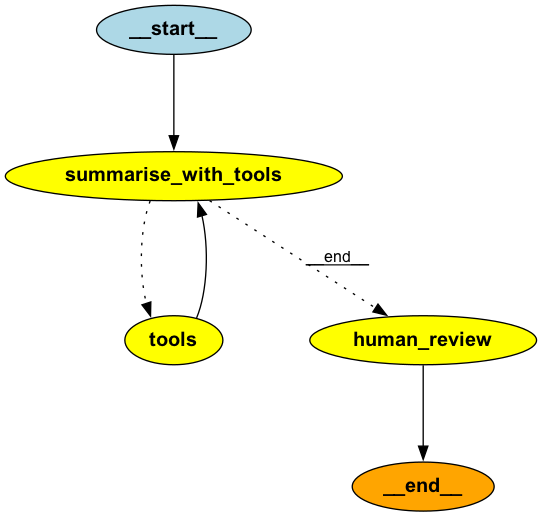

In [13]:
# --- 3️⃣ Add a MemorySaver for Persistent State ---

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Compile the new graph with MemorySaver as checkpointer
app_stage3 = customer_complaint_bot_with_tools.compile(checkpointer=memory)


# --- Visualize the Graph ---
graph = app_stage3.get_graph()
png_bytes = graph.draw_png()
display(Image(png_bytes))


In [14]:
thread_id

'session_bc459ea6'

In [15]:
# --- 5️⃣ Example: Run the Graph and Handle HITL Feedback ---

# Customer email that will trigger the workflow
new_complaint_email = (
    "Hello, I ordered the 'MegaWidget 2000' with order ID B-54321 two days ago, "
    "but I haven't received any shipping updates. Can you check the status of my order? "
    "Also, I want to confirm the price I was charged."
)

new_inputs = {"messages": [HumanMessage(content=new_complaint_email)]}

# Step 1: Invoke until the graph pauses for human feedback
result = app_stage3.invoke(new_inputs, config={"configurable": {"thread_id": thread_id}})




INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.
INFO:customer_complaint_bot:Retrieving details for order ID: B-54321


LLM Response: content='' additional_kwargs={'reasoning_content': 'We need to retrieve order details via function get_order_details with order_id "B-54321". Then summarize complaint and interpret tool results.', 'tool_calls': [{'id': 'fc_56a9067e-683a-4f6a-8757-81a185602f75', 'function': {'arguments': '{"order_id":"B-54321"}', 'name': 'get_order_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 246, 'total_tokens': 303, 'completion_time': 0.057923813, 'prompt_time': 0.013798539, 'queue_time': 0.0362934, 'total_time': 0.071722352, 'completion_tokens_details': {'reasoning_tokens': 29}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e189667b30', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--4c9dd718-a755-447f-9405-1ac62ed4d664-0' tool_calls=[{'name': 'get_order_details', 'args': {'order_id': 'B-54321'}, 'id': 'fc_56a9067e-683a-4f6a-8757-81a185602

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.
INFO:customer_complaint_bot:Pausing for human feedback on the generated summary.


LLM Response: content='**Customer’s Complaint (summarised)**  \nThe customer ordered the *MegaWidget\u202f2000* (Order\u202fID\u202fB‑54321) two days ago and has not yet received any shipping updates. They would like to know the current status of the shipment and confirm the amount that was charged.\n\n**Interpretation of the tool output**  \n- **Product**: MegaWidget\u202f2000  \n- **Order status**: **Shipped**  \n- **Price charged**: **£149**\n\n**Response**  \nHi there,\n\nThank you for reaching out. I’ve pulled up your order details:\n\n| Item | Detail |\n|------|--------|\n| **Product** | MegaWidget\u202f2000 |\n| **Order ID** | B‑54321 |\n| **Current status** | **Shipped** |\n| **Amount charged** | **£149** |\n\nYour package has already left our warehouse and is on its way to you. You should receive a tracking number and further shipping updates within the next 24\u202fhours. If you’d like me to send the tracking details right away, just let me know.\n\nPlease feel free to ask if

In [ ]:
# --- 5️⃣ Example: Run the Graph and *Truly* Handle HITL Feedback ---

# (We'll use the thread_id and new_complaint_email from previous cells)
config = {"configurable": {"thread_id": thread_id}}
new_inputs = {"messages": [HumanMessage(content=new_complaint_email)]}

# --- Step 1: Invoke until the graph pauses ---
print("--- 🚀 Starting workflow... ---")
# This call will PAUSE at 'human_review' and return the current state
interrupted_state = app_stage3.invoke(new_inputs, config=config)

print("\n--- ⏸️ WORKFLOW PAUSED FOR HUMAN REVIEW ---")

# --- Step 2: Show the human (you) what to review ---
# Get the AI's draft response from the interrupted state
ai_draft = ""
for msg in reversed(interrupted_state.get("messages", [])):
    if msg.__class__.__name__ == "AIMessage" and msg.content.strip():
        ai_draft = msg.content
        break

print(f"\n📨 Original Email:\n{interrupted_state['original_email']}\n")
print(f"🤖 AI-Generated Draft:\n{ai_draft}\n")

# --- Step 3: Get REAL feedback from the user via input() ---
print("--- 🧑‍💼 WAITING FOR YOUR INPUT ---")
print("Provide feedback/edits (or just press Enter to approve the draft as-is):")
feedback_comment = input()

human_feedback = {}
if feedback_comment:
    # If you provided feedback, you must also provide the *new* summary
    print("\nPlease provide the new, approved summary:")
    approved_summary = input()
    human_feedback = {
        "approved_summary": approved_summary,
        "comment": feedback_comment
    }
else:
    # If you just pressed Enter, approve the original draft
    print("--- ✅ No feedback provided. Approving original draft... ---")
    human_feedback = {
        "approved_summary": ai_draft, # Approve the original draft
        "comment": "Approved as-is."
    }

# --- Step 4: Resume the graph with your feedback ---
print("--- 🔄 Resuming workflow... ---")
# We use invoke() again with the same thread_id to resume
final_result = app_stage3.invoke(human_feedback, config=config)

# --- 6️⃣ Display Final Results (unchanged from your notebook) ---
print("\n✅ Workflow Completed with Human Review\n")
print("Final Summary:", final_result.get("summary"), "\n")

print("Conversation Messages:")
for msg in final_result.get("messages", []):
    print(f"- {msg.__class__.__name__}: {msg.content}\n")

# --- 7️⃣ Optional: Inspect Persisted Memory (unchanged) ---
print("🧠 Memory State Saved:")
print(app_stage3.get_state(config))

--- 🚀 Starting workflow... ---


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.
INFO:customer_complaint_bot:Retrieving details for order ID: B-54321


LLM Response: content='' additional_kwargs={'reasoning_content': 'We need to retrieve order details via function get_order_details with order_id "B-54321". Then summarize complaint and interpret tool results.', 'tool_calls': [{'id': 'fc_1336c2f8-aba5-40f2-9faf-916053292491', 'function': {'arguments': '{"order_id":"B-54321"}', 'name': 'get_order_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 246, 'total_tokens': 303, 'completion_time': 0.056034893, 'prompt_time': 0.013786154, 'queue_time': 0.037277523, 'total_time': 0.069821047, 'completion_tokens_details': {'reasoning_tokens': 29}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_a239821cdc', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--7c52b729-2bb1-4c7d-9235-3057ca448d9f-0' tool_calls=[{'name': 'get_order_details', 'args': {'order_id': 'B-54321'}, 'id': 'fc_1336c2f8-aba5-40f2-9faf-9160532

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.
INFO:customer_complaint_bot:Pausing for human feedback on the generated summary.


LLM Response: content='**Customer Complaint Summary**  \nThe customer ordered the *MegaWidget\u202f2000* (Order\u202fID\u202fB‑54321) two days ago and has not received any shipping updates. They are asking for the current status of the shipment and confirmation of the price charged.\n\n**Interpretation of Tool Result**  \nThe order details retrieved show:\n- **Product:** MegaWidget\u202f2000  \n- **Status:** Shipped  \n- **Price Charged:** £149  \n\n**Response**  \nHi there! I’ve pulled up the details for your order (B‑54321). Your *MegaWidget\u202f2000* has already been shipped, and you were charged **£149**. If you’d like a tracking number or any additional information, just let me know and I’ll provide it right away. Thanks for your patience!' additional_kwargs={'reasoning_content': 'We need to summarize the complaint and interpret tool results. The user says they ordered MegaWidget 2000 with order ID B-54321 two days ago, no shipping updates. They want status and price confirmation

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:customer_complaint_bot:Summary generated successfully.
INFO:customer_complaint_bot:Pausing for human feedback on the generated summary.


LLM Response: content='**Customer’s concern**  \nThe customer ordered the *MegaWidget\u202f2000* (Order\u202fID\u202fB‑54321) two days ago and has not yet received any shipping updates. They would like to know the current status of the shipment and confirm the amount that was charged.\n\n**Tool output interpretation**  \n- **Product**: MegaWidget\u202f2000  \n- **Order status**: *Shipped*  \n- **Price charged**: £149  \n\n**Response**  \nHi there,\n\nThanks for reaching out. I’ve pulled up your order details:\n\n- **Order ID**: B‑54321  \n- **Product**: MegaWidget\u202f2000  \n- **Current status**: **Shipped** – the item left our warehouse yesterday.  \n- **Price charged**: **£149**\n\nYou should receive a tracking number and further shipping updates within the next 24\u202fhours. If you don’t see an email with the tracking details by then, please let me know and I’ll investigate further.\n\nIs there anything else I can help you with today?' additional_kwargs={'reasoning_content': 'We 

AttributeError: 'InMemorySaver' object has no attribute 'get_state'

In [16]:
# --- 7️⃣ Optional: Inspect Persisted Memory (unchanged) ---
print("🧠 Memory State Saved:")
print(app_stage3.get_state(config))

🧠 Memory State Saved:
StateSnapshot(values={'messages': [HumanMessage(content="Hello, I ordered the 'MegaWidget 2000' with order ID B-54321 two days ago, but I haven't received any shipping updates. Can you check the status of my order? Also, I want to confirm the price I was charged.", additional_kwargs={}, response_metadata={}, id='88671b9b-6d7d-432b-b035-a7e9e9fa1719'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to retrieve order details via function get_order_details with order_id "B-54321". Then summarize complaint and interpret tool results.', 'tool_calls': [{'id': 'fc_1336c2f8-aba5-40f2-9faf-916053292491', 'function': {'arguments': '{"order_id":"B-54321"}', 'name': 'get_order_details'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 246, 'total_tokens': 303, 'completion_time': 0.056034893, 'prompt_time': 0.013786154, 'queue_time': 0.037277523, 'total_time': 0.069821047, 'completion_tokens_details': 

In [ ]:
# When `interrupt()` triggers, LangGraph will emit an interrupt event.
# Simulate a human response here (in production, this could come from a UI or dashboard)
human_feedback = {
    "approved_summary": (
        "Customer is asking about shipping status and price confirmation for order B-54321 "
        "(MegaWidget 2000). Status: Shipped, Price: £149."
    ),
    "comment": "Approved. Clarified product details and confirmed order info."
}

# # Step 2: Resume the graph with human feedback
# final_result = app_stage3.invoke(human_feedback, config={"configurable": {"thread_id": thread_id}}) 


# # --- 6️⃣ Display Final Results ---

# print("\n✅ Workflow Completed with Human Review\n")
# print("Final Summary:", final_result.get("summary"), "\n")

# print("Conversation Messages:")
# for msg in final_result.get("messages", []):
#     print(f"- {msg.__class__.__name__}: {msg.content}\n")

# # --- 7️⃣ Optional: Inspect Persisted Memory ---
# print("🧠 Memory State Saved:")
# print(memory.get_state())